In [26]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [73]:
import re
import pandas as pd 
# 查看客流量数据集
df = pd.read_csv('data/客流量数据.csv')
df.interpolate(method="linear", axis=0, inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234614 entries, 0 to 234613
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   时间      234614 non-null  int64 
 1   时间区段    234614 non-null  object
 2   站点      234614 non-null  object
 3   进站数量    234614 non-null  int64 
 4   出站数量    234614 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 8.9+ MB


,时间,时间区段,站点,进站数量,出站数量
0,20220101,00:00:00-00:14:59,G站,63,21
1,20220101,00:00:00-00:14:59,F站,42,84
2,20220101,00:00:00-00:14:59,E站,0,105
3,20220101,00:00:00-00:14:59,D站,42,126
4,20220101,00:00:00-00:14:59,C站,42,105


In [28]:
# 查看test数据集
tf = pd.read_csv('data/test.csv')
tf.info()
tf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     672 non-null    object
 1   InNum    672 non-null    int64 
 2   OutNum   672 non-null    int64 
 3   Station  672 non-null    object
dtypes: int64(2), object(2)
memory usage: 21.1+ KB


,Time,InNum,OutNum,Station
0,2023/4/15 0:00,10,5,A
1,2023/4/15 0:15,2,1,A
2,2023/4/15 0:30,0,1,A
3,2023/4/15 0:45,0,0,A
4,2023/4/15 1:00,0,0,A


In [29]:
# 查看reslut数据集
rf = pd.read_csv('data/result.csv')
rf.info()
rf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     672 non-null    object 
 1   InNum    0 non-null      float64
 2   OutNum   0 non-null      float64
 3   Station  672 non-null    object 
dtypes: float64(2), object(2)
memory usage: 21.1+ KB


,Time,InNum,OutNum,Station
0,2023/4/16 0:00,NaN,NaN,A
1,2023/4/16 0:15,NaN,NaN,A
2,2023/4/16 0:30,NaN,NaN,A
3,2023/4/16 0:45,NaN,NaN,A
4,2023/4/16 1:00,NaN,NaN,A


In [30]:
dic = {'A':1, 'B':2, 'C':3,'D':4, 'E':5,'F':6,'G':7}

In [74]:
def extract_station(x):
    station = re.compile('([A-Z])站').findall(x)
    if len(station)>0:
        return dic[station[0]]

df["时间区段"] = df["时间区段"].apply(lambda x:x.split("-")[0])
df["站点"] = df["站点"].apply(extract_station)
df["时间"] = df["时间"].apply(lambda x:str(x)).str.cat(df['时间区段'],sep=" ")
df["时间"] = pd.to_datetime(df["时间"])
df = df.drop("时间区段",axis=1)
df.columns =["Time", "Station", "InNum", "OutNum"]

In [76]:
df['Station'] = df['Station'].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234614 entries, 0 to 234613
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Time     234614 non-null  datetime64[ns]
 1   Station  234614 non-null  float32       
 2   InNum    234614 non-null  int64         
 3   OutNum   234614 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int64(2)
memory usage: 6.3 MB


In [11]:
# 如果环境没配置好要运行这两行
#!pip install --upgrade pip

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
#!pip install paddlets -t /home/aistudio/external-libraries

In [77]:
import paddle
from paddlets.datasets.tsdataset import TSDataset
from paddlets.transform import TimeFeatureGenerator, StandardScaler
from paddlets.models.forecasting import LSTNetRegressor
from paddlets.metrics import MAE
import warnings
warnings.filterwarnings('ignore')

In [78]:
dataset_df = TSDataset.load_from_dataframe(
    df = df[df.Station < 8],
    group_id = 'Station',
    time_col = 'Time',
    target_cols=['InNum','OutNum'], #预测目标
    static_cov_cols='Station',  # static_cov_cols是否传递并指定为group_id是可选的，如果设置了改选项，group_id 将作为静态协变量加入模型的训练。
    freq='15min',
    fill_missing_dates=True,
    fillna_method='zero'
)

In [67]:
pd.isnull(dataset_df).any()

False

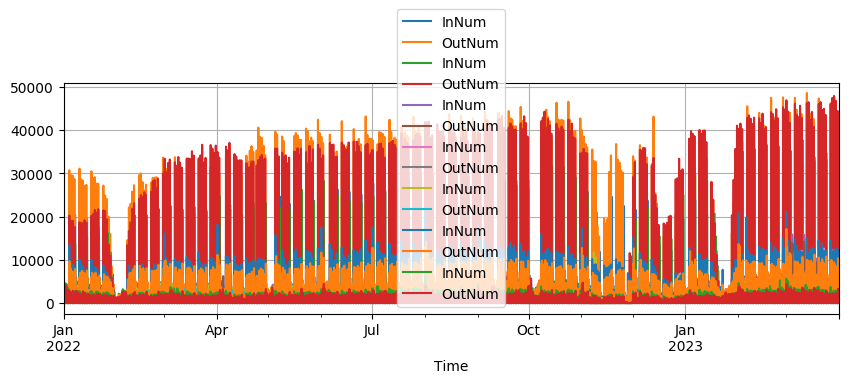

In [59]:
for i in dataset_df:
    i.plot()

In [79]:
data_train = []  # 训练集
data_val_test = []  # 测试集和验证集
data_val = []  # 验证集
data_test = [] # 测试集
# 因为分组后有七组数据
for i in dataset_df:
    data1 , data2= i.split("2023-02-05 23:45:00")
    data3, data4 = data2.split("2023-03-29 23:45:00")
    data_train.append(data1)
    data_val_test.append(data2)
    data_val.append(data3)
    data_test.append(data4)


In [80]:
# 数据归一化
scaler = StandardScaler()
scaler.fit(data_train)

data_train_scaled = scaler.transform(data_train)
data_val_test_scaled = scaler.transform(data_val_test)
data_val_scaled = scaler.transform(data_val)
data_test_scaled = scaler.transform(data_test)

In [70]:
paddle.seed(2023)
model = LSTNetRegressor(
    in_chunk_len = 4*24,
    out_chunk_len = 4*24,
    max_epochs = 1,
    patience = 1,
    eval_metrics =["mae"],
    optimizer_params= dict(learning_rate=3e-3)
)

In [81]:
model.fit(data_train_scaled, data_val_scaled)


[2023-05-31 21:19:12,398] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.325027| val_0_mae: 0.279297| 0:01:46s
[2023-05-31 21:20:58,316] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.313328| val_0_mae: 0.270488| 0:03:32s
[2023-05-31 21:22:44,948] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.312119| val_0_mae: 0.261941| 0:05:18s
[2023-05-31 21:24:30,932] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.310809| val_0_mae: 0.267429| 0:07:04s
[2023-05-31 21:26:17,681] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.309848| val_0_mae: 0.292265| 0:08:51s
[2023-05-31 21:28:04,398] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.308953| val_0_mae: 0.274761| 0:10:38s
[2023-05-31 21:29:49,943] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.308406| val_0_mae: 0.308843| 0:12:23s
[2023-05-31 21:31:37,704] [paddlets.models.common.callb

[2023-05-31 22:55:22,399] [paddlets.utils.backtest] [INFO] Parameter 'predict_window' not set, default set to model.out_chunk_len 96
[2023-05-31 22:55:22,401] [paddlets.utils.backtest] [INFO] Parameter 'stride' not set, default set to predict_window 96
[2023-05-31 22:55:22,402] [paddlets.utils.backtest] [INFO] Parameter 'start' not set, default set to model_in_chunk_len 96 + skip_chunk_len 0
[2023-05-31 22:55:22,661] [paddlets.utils.utils] [WARNING] error occurred while import autots, err: No module named 'ray'
Backtest Progress: 100%|██████████| 1/1 [00:00<00:00, 40.09it/s]
[2023-05-31 22:55:22,770] [paddlets.utils.backtest] [INFO] Parameter 'predict_window' not set, default set to model.out_chunk_len 96
[2023-05-31 22:55:22,771] [paddlets.utils.backtest] [INFO] Parameter 'stride' not set, default set to predict_window 96
[2023-05-31 22:55:22,772] [paddlets.utils.backtest] [INFO] Parameter 'start' not set, default set to model_in_chunk_len 96 + skip_chunk_len 0
[2023-05-31 22:55:22,77

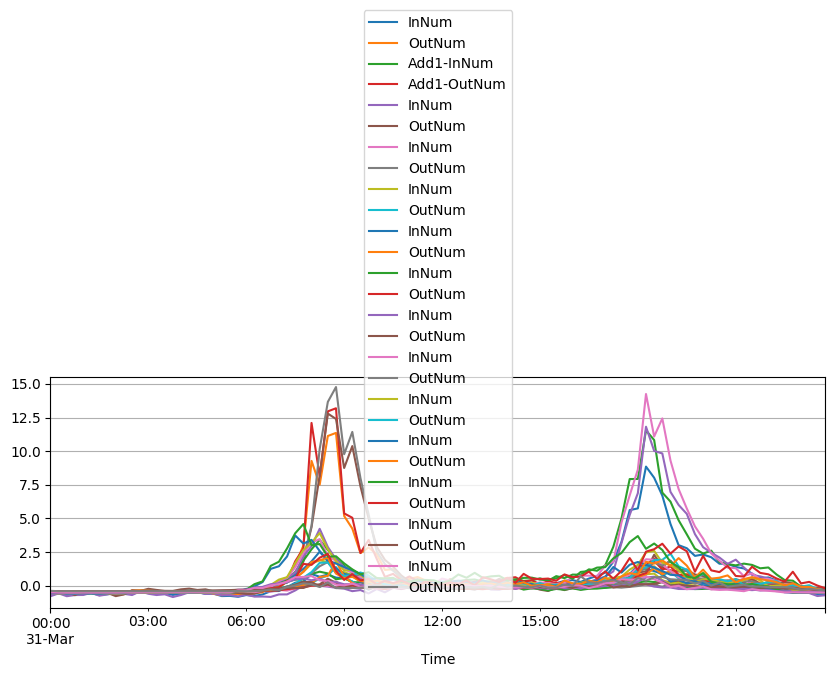

In [101]:
# 数据回测
from paddlets.utils import backtest
from paddlets.metrics import MAE
maes = []
for data in data_test_scaled:
    mae, pred = backtest(data=data,
                    model=model,
                    metric=MAE(),
                    return_predicts=True
    )
    # 最后一天的客流量预测值
    _, ground_truth = data.split("2023-03-30 23:45:00")
    # 最后一天预测值与真实值比较
    pred.plot(add_data = ground_truth)
    maes.append(mae)

In [103]:
maes

[{'InNum': 0.39909004004492327, 'OutNum': 0.25306405069845805},
 {'InNum': 0.36357608743973985, 'OutNum': 0.22846333597993262},
 {'InNum': 0.11979026291804794, 'OutNum': 0.07086964422778733},
 {'InNum': 0.10545080584737689, 'OutNum': 0.09522588831690117},
 {'InNum': 0.14496338591775162, 'OutNum': 0.09876232017576887},
 {'InNum': 0.33684773724574707, 'OutNum': 0.2901453588199297},
 {'InNum': 0.09592718592258138, 'OutNum': 0.11215582096998462}]

[{'InNum': 0.39909004004492327, 'OutNum': 0.25306405069845805},
 {'InNum': 0.36357608743973985, 'OutNum': 0.22846333597993262},
 {'InNum': 0.11979026291804794, 'OutNum': 0.07086964422778733},
 {'InNum': 0.10545080584737689, 'OutNum': 0.09522588831690117},
 {'InNum': 0.14496338591775162, 'OutNum': 0.09876232017576887},
 {'InNum': 0.33684773724574707, 'OutNum': 0.2901453588199297},
 {'InNum': 0.09592718592258138, 'OutNum': 0.11215582096998462}]

图像y轴坐标数值都比较小，这是由于没有将数据反标准化导致的。因此，我们需要用scaler.inverse_transform方法对预测数据进行反标准化处理。 发现有一些数据值是小于0的，而且同时很多数据值都是浮点型，这是由于我们用的是自回归建模方法，但负值的数据是明显不合理的。因此要做到以下两点 1.将负值改为0； 2.将浮点数类型转化为整数类型

In [ ]:
ground_truth_inverse = scaler.inverse_transform(ground_truth)
pred_inverse  scaler.inverse_transform(pred)
pred_inverse.plot(add_data=ground_truth_inverse)

模型保存

模型训练完成后，将模型固化成文件保存在本地，方便后续的推理工作。这部分使用的是PaddleTS模型自带的save()函数。同时，也要注意将数据标准化的参数保存，用于后续推理前进行数据预处理。



In [86]:
import os
import pickle

model_save_path = os.path.join("models/lstm")
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
model.save(os.path.join(model_save_path, "model"))
pickle.dump(scaler, open(os.path.join(model_save_path,"scaler.pkl"),'wb'))

In [87]:
import pandas as pd
from paddlets.datasets.tsdataset import TSDataset
from paddlets.transform import TimeFeatureGenerator, StandardScaler
import pickle
import os
from paddlets.models.model_loader import load

In [88]:
# dataset_test_df = pd.read_csv("data/test.csv")  # 单站点预测
# station = "A" # 站点
# dataset_test_df = dataset_test_df[dataset_test_df['Station']==station]

# dataset_test_df = TSDataset.load_from_dataframe(
#     dataset_test_df,
#     time_col = 'Time',
#     target_cols=['InNum','OutNum'], #预测目标
#     freq='15min',
#     fill_missing_dates=True,
# )

# dataset_test_df

                     InNum  OutNum
Time                              
2023-04-15 00:00:00     10       5
2023-04-15 00:15:00      2       1
2023-04-15 00:30:00      0       1
2023-04-15 00:45:00      0       0
2023-04-15 01:00:00      0       0
...                    ...     ...
2023-04-15 22:45:00      0      63
2023-04-15 23:00:00      2      43
2023-04-15 23:15:00      0      24
2023-04-15 23:30:00      0      24
2023-04-15 23:45:00      0      20

[96 rows x 2 columns]

In [89]:
# 加载标准化处理参数，对测试数据进行标准化预处理。
# with open("models/lstm/scaler.pkl", "rb") as r:
#     scaler = pickle.load(r)
# dataset_test_scaled = scaler.transform(dataset_test_df)
# dataset_test_scaled

                        InNum    OutNum
Time                                   
2023-04-15 00:00:00 -0.499341 -0.408889
2023-04-15 00:15:00 -0.502649 -0.410256
2023-04-15 00:30:00 -0.503476 -0.410256
2023-04-15 00:45:00 -0.503476 -0.410598
2023-04-15 01:00:00 -0.503476 -0.410598
...                       ...       ...
2023-04-15 22:45:00 -0.503476 -0.389068
2023-04-15 23:00:00 -0.502649 -0.395903
2023-04-15 23:15:00 -0.503476 -0.402396
2023-04-15 23:30:00 -0.503476 -0.402396
2023-04-15 23:45:00 -0.503476 -0.403763

[96 rows x 2 columns]

将保存好的模型重新加载，调用.predict函数对测试数据进行预测，对预测结果进行反标准化，再处理负值和浮点型问题即可输出为结果文件。

In [91]:
# model = load("models/lstm/model")
# res = model.predict(dataset_test_scaled)
# res_inversed = scaler.inverse_transform(res)
# res_inversed = res_inversed.to_dataframe(copy=True)
# res_inversed["InNum"] = res_inversed["InNum"].apply(lambda x:0 if x<0 else int(x))
# res_inversed["OutNum"] = res_inversed["OutNum"].apply(lambda x:0 if x<0 else int(x))
# res_inversed["Station"] = station # 添加站点标识
# res_inversed.index.name = "Time"
# # 输出结果文件
# if not os.path.exists("./results"):
#     os.makedirs("./results")
# res_inversed.to_csv("results/{}_result.csv".format(station))
# res_inversed.head()

,InNum,OutNum,Station
Time,,,
2023-04-16 00:00:00,0,0,A
2023-04-16 00:15:00,0,0,A
2023-04-16 00:30:00,0,4,A
2023-04-16 00:45:00,0,9,A
2023-04-16 01:00:00,0,30,A


In [96]:
dataset_test_df = pd.read_csv("data/test.csv")

# 分站点进行预测循环预测
def predictdata(station):
    
    data_test = dataset_test_df[dataset_test_df['Station']==station]
    data_test = TSDataset.load_from_dataframe(
        data_test,
        time_col = 'Time',
        target_cols=['InNum','OutNum'], #预测目标
        freq='15min',
        fill_missing_dates=True,
    )
    data_test
    # 加载标准化处理参数，对测试数据进行标准化预处理。
    with open("models/lstm/scaler.pkl", "rb") as r:
        scaler = pickle.load(r)
    dataset_test_scaled = scaler.transform(data_test)
    dataset_test_scaled

    #将保存好的模型重新加载，调用.predict函数对测试数据进行预测，对预测结果进行反标准化，再处理负值和浮点型问题即可输出为结果文件。
    model = load("models/lstm/model")
    res = model.predict(dataset_test_scaled)
    res_inversed = scaler.inverse_transform(res)
    res_inversed = res_inversed.to_dataframe(copy=True)
    res_inversed["InNum"] = res_inversed["InNum"].apply(lambda x:0 if x<0 else int(x))
    res_inversed["OutNum"] = res_inversed["OutNum"].apply(lambda x:0 if x<0 else int(x))
    res_inversed["Station"] = station # 添加站点标识
    res_inversed.index.name = "Time"
    # 输出结果文件
    if not os.path.exists("./results"):
        os.makedirs("./results")
    res_inversed.to_csv("results/{}_result.csv".format(station))
    res_inversed.head()
stations = ['A', 'B', 'C','D','E','F','G']
for station in stations:
    predictdata(station)

In [98]:
df1=pd.read_csv("results/A_result.csv")
df2=pd.read_csv("results/B_result.csv")
df3=pd.read_csv("results/C_result.csv")
df4=pd.read_csv("results/D_result.csv")
df5=pd.read_csv("results/E_result.csv")
df6=pd.read_csv("results/F_result.csv")
df7=pd.read_csv("results/G_result.csv")

merged_df=pd.concat([df1,df2,df3,df4,df5,df6,df7])
merged_df.head()
merged_df.to_csv("results/result.csv", index=False)





In [100]:
# 时间格式错误，用reslut文件的时间替代
df = pd.read_csv('data/result.csv')
rf = pd.read_csv('results/result.csv')

rf['Time'] = df['Time']
rf.to_csv("results/{}.csv".format('预测客流量'), index=False)